In [8]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
df = pd.read_csv('/kaggle/input/fundus-dataset/dataset.csv')

In [10]:
df

,image_path,class
0,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other
1,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other
2,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other
3,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other
4,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other
...,...,...
4507,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia
4508,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia
4509,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia
4510,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia


In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Görüntüleri yükleme ve ön işleme fonksiyonu
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path).resize(target_size)  # Görüntüyü yeniden boyutlandır
    image = np.array(image) / 255.0  # Normalizasyon (0-1 aralığına getir)
    return image


# One-hot encoding işlemi
y = to_categorical(df['label_encoded'])

# Görüntüleri ve etiketleri yükleme
X = np.array([load_and_preprocess_image(path) for path in df['image_path']])

# Veriyi eğitim, doğrulama ve test setlerine ayırma
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # %70 eğitim, %30 geçici
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # %15 doğrulama, %15 test

print("Eğitim verisi şekli:", X_train.shape)
print("Doğrulama verisi şekli:", X_val.shape)
print("Test verisi şekli:", X_test.shape)


Eğitim verisi şekli: (3158, 224, 224, 3)
Doğrulama verisi şekli: (677, 224, 224, 3)
Test verisi şekli: (677, 224, 224, 3)


In [12]:
df

,image_path,class,label_encoded
0,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
1,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
2,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
3,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
4,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Other,7
...,...,...,...
4507,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4508,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4509,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5
4510,/kaggle/input/fundus-dataset/Fundus Dataset/Fu...,Myopia,5


In [14]:
import tensorflow as tf
class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=3):  # Daha küçük kernel boyutu
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv = Conv2D(filters=1, kernel_size=self.kernel_size, strides=1, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        spatial_attention = self.conv(concat)
        return Multiply()([inputs, spatial_attention])

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Multiply

# Channel Attention sınıfı
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[-1]  # Kanal sayısı
        self.avg_dense = Dense(channels // self.reduction_ratio, activation='relu', use_bias=True)
        self.max_dense = Dense(channels // self.reduction_ratio, activation='relu', use_bias=True)
        self.output_dense = Dense(channels, activation='sigmoid', use_bias=True)

    def call(self, inputs):
        avg_pool = GlobalAveragePooling2D()(inputs)
        avg_pool = Reshape((1, 1, -1))(avg_pool)
        avg_out = self.output_dense(self.avg_dense(avg_pool))

        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        max_out = self.output_dense(self.max_dense(max_pool))

        channel_attention = tf.keras.activations.sigmoid(avg_out + max_out)
        return Multiply()([inputs, channel_attention])

In [16]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
import numpy as np


In [17]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = ChannelAttention()(x)
x = SpatialAttention()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.losses import CategoricalFocalCrossentropy

for layer in base_model.layers[-15:]:
    layer.trainable = True

# Cyclical Learning Rate fonksiyonu
def cyclical_learning_rate(epoch, initial_lr=1e-6, max_lr=5e-5, step_size=1000, scale_fn=lambda x: 1 / (2.0 ** (x - 1))):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = initial_lr + (max_lr - initial_lr) * np.maximum(0, (1 - x)) * scale_fn(cycle)
    return lr

# Learning Rate Scheduler tanımla
lr_scheduler = LearningRateScheduler(cyclical_learning_rate)


# Early stopping callback'i tanımla
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Öğrenme oranını dinamik olarak azalt
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)


model.compile(
    optimizer=AdamW(learning_rate=5e-5, weight_decay=1e-3),
    loss=CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, label_smoothing=0.1),
    metrics=['accuracy']
)
# Model eğitimi
# Modeli eğitme
history = model.fit(
    X_train, y_train,                # Eğitim verisi
    batch_size=32,                   # Batch size
    epochs=100,                      # Epoch sayısı
    validation_data=(X_val, y_val),  # Doğrulama verisi
    callbacks=[early_stopping, reduce_lr, lr_scheduler]  # Callback'ler
)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 136s 630ms/step - accuracy: 0.1428 - loss: 1.0213 - val_accuracy: 0.1004 - val_loss: 0.9839 - learning_rate: 5.0000e-05
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.2441 - loss: 0.9553 - val_accuracy: 0.1241 - val_loss: 0.9728 - learning_rate: 5.0000e-05
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.3224 - loss: 0.9138 - val_accuracy: 0.1344 - val_loss: 0.9646 - learning_rate: 5.0000e-05
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.4118 - loss: 0.8719 - val_accuracy: 0.1004 - val_loss: 0.9570 - learning_rate: 5.0000e-05
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.4190 - loss: 0.8482 - val_accuracy: 0.1211 - val_loss: 0.9457 - learning_rate: 5.0000e-05
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.4483 - loss: 0.8174 - val_accuracy: 0.1300 - val_loss: 0.9371 - learning_rate: 5.0000e-05
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/st

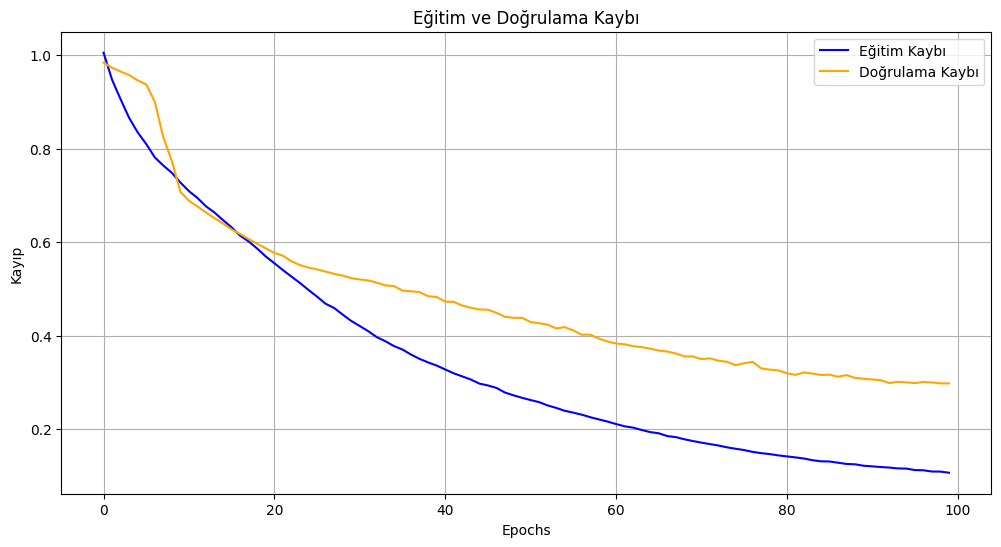

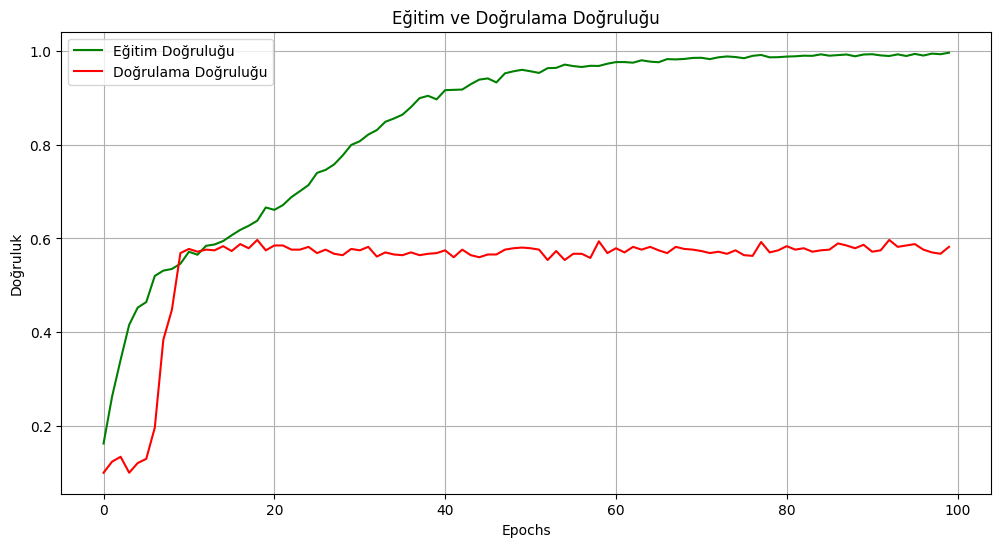

In [19]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kaybını çizdir
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='blue')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='orange')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.grid()
plt.show()

# Eğitim ve doğrulama doğruluğunu çizdir
if 'accuracy' in history.history:  # Model doğruluk metriğini içeriyorsa
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='green')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='red')
    plt.title('Eğitim ve Doğrulama Doğruluğu')
    plt.xlabel('Epochs')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Doğruluk metrikleri bulunamadı. Lütfen modelinize doğruluk metriği eklediğinizden emin olun.")
